## 1. Cài đặt và Import thư viện

In [ ]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import StackingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import warnings

warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

## 2. Đọc và khám phá bộ dữ liệu

In [ ]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large")
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [ ]:
all_categories = ds['train']['categories']
category_set = set()

for category in all_categories:
  parts = category.split(' ')
  for part in parts:
    topic = part.split('.')[0]
    category_set.add(topic)

sorted_categories = sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
  print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [ ]:
# # load 20000 samples with single label belonging to specific categories
# samples = []
# CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
# category_counts = defaultdict(int)
# quota = 50000 // len(CATEGORIES_TO_SELECT)


# for s in ds['train']:
#     # bỏ các bản ghi có nhiều hơn 1 category
#     if len(s['categories'].split(' ')) != 1:
#         continue

#     # lấy group chính (vd: "cs.CL" -> "cs")
#     cur_category = s['categories'].strip().split('.')[0]
#     if cur_category not in CATEGORIES_TO_SELECT:
#         continue

#     # check abstract/title khác None và không rỗng
#     if not s['title'] or not s['abstract']:
#         continue
#     if s['title'].strip() == "" or s['abstract'].strip() == "":
#         continue

#     # nếu chưa đủ quota thì lấy
#     if category_counts[cur_category] < quota:
#         samples.append(s)
#         category_counts[cur_category] += 1

#     if all(category_counts[c] >= quota for c in CATEGORIES_TO_SELECT):
#         break

# print(f"Number of samples: {len(samples)}")
# print(f"Number of samples of each category: {dict(category_counts)}")


# # in thử vài mẫu
# for sample in samples[:3]:
#     print(f"Category: {sample['categories']}")
#     print("Abstract:", sample['abstract'][:300], "...")
#     print("#" * 20 + "\n")


In [ ]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']

# Shuffle the training dataset
shuffled_ds_train = ds['train'].shuffle(seed=42)

for s in shuffled_ds_train:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 25000:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 25000
Category: physics.acc-ph
Abstract:   Recently a mechanism of storage ring operation based on the steady-state
microbunching has been proposed and investigated, which contains a laser cavity
modulator providing the longitudinal focusing for the circulating microbunches.
In this paper we analyze the impact of the coherent undulator radiation on the
longitudinal single-bunch multi-turn collective dynamics, exploring a new
possible instability mechanism. We formulate the multi-turn equations of motion
for the single microbunch as two sets of difference equations in the modulator
and in the remaining storage ring. The dispersion equation can then be obtained
by introduction of the undulator-averaged phase space coordinates. The
predicted instability growth rate shows reasonable agreement with the numerical
turn-by-turn tracking simulations provided validity of the underlying
assumptions. The analysis shall provide some insights for the coherent
undulator radiation d

In [ ]:
ds['train'][0]

{'id': '0704.0001',
 'submitter': 'Pavel Nadolsky',
 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
 'comments': '37 pages, 15 figures; published version',
 'journal-ref': 'Phys.Rev.D76:013009,2007',
 'doi': '10.1103/PhysRevD.76.013009',
 'report-no': 'ANL-HEP-PR-07-12',
 'categories': 'hep-ph',
 'license': None,
 'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from th

In [ ]:
type(ds)

datasets.dataset_dict.DatasetDict

## 3. Tiền xử lý dữ liệu

In [ ]:
preprocessed_samples = []
for s in samples:
    # Combine abstract and title
    abstract_title = s['title'] + " " + s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract_title = abstract_title.strip().replace("\n", " ")

    # Remove special characters
    abstract_title = re.sub(r'[^\w\s]', '', abstract_title)

    # Remove digits
    abstract_title = re.sub(r'\d+', '', abstract_title)

    # Remove extra spaces
    abstract_title = re.sub(r'\s+', ' ', abstract_title).strip()

    # Convert to lower case
    abstract_title = abstract_title.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract_title,
        "label": category
    })

# print first 3 preprocessed samples
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: longitudinal singlebunch instabilities driven by coherent undulator radiation in the cavity modulator of a steadystate microbunching storage ring recently a mechanism of storage ring operation based on the steadystate microbunching has been proposed and investigated which contains a laser cavity modulator providing the longitudinal focusing for the circulating microbunches in this paper we analyze the impact of the coherent undulator radiation on the longitudinal singlebunch multiturn collective dynamics exploring a new possible instability mechanism we formulate the multiturn equations of motion for the single microbunch as two sets of difference equations in the modulator and in the remaining storage ring the dispersion equation can then be obtained by introduction of the undulatoraveraged phase space coordinates the predicted instability growth rate shows reasonable agreement with the numerical turnbyturn tracking simulations provided validity of the underlying 

In [ ]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [ ]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [ ]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]
X_train, X_test, y_train, y_test = train_test_split(X_full,
                                                    y_full,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_full)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 20000
Testing samples: 5000


In [ ]:
df_2 = pd.DataFrame(X_train)
df_2.duplicated().sum()

np.int64(0)

In [ ]:
from collections import Counter
import pandas as pd
label_counts = Counter(y_train)
print("Counts of each label in the training data:")
for label_id, count in sorted(label_counts.items()):
    label_name = id_to_label[label_id]
    print(f"{label_name} ({label_id}): {count}")

Counts of each label in the training data:
astro-ph (0): 4396
cond-mat (1): 3652
cs (2): 4285
math (3): 5842
physics (4): 1825


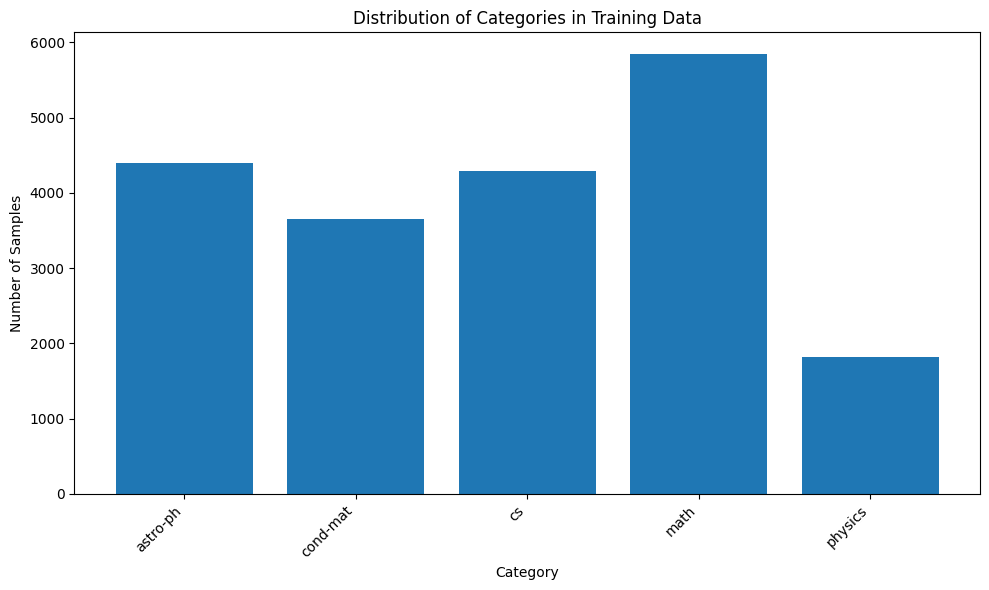

In [ ]:
import matplotlib.pyplot as plt

# Get labels and counts from the Counter object
labels_train = [id_to_label[label_id] for label_id in sorted(label_counts.keys())]
counts_train = [label_counts[label_id] for label_id in sorted(label_counts.keys())]

plt.figure(figsize=(10, 6))
plt.bar(labels_train, counts_train)
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.title("Distribution of Categories in Training Data")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

## EMBEDDING MODEL: intfloat/multilingual-e5-base

### 4. Mã hóa văn bản (Sentence Embeddings)




In [ ]:
# Embedding Model: intfloat/multilingual-e5-base
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = 'intfloat/multilingual-e5-base',
        normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def transform(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> List[List[float]]:
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))

#### Orginal Dataset

In [ ]:
embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Shape of X_train_embeddings: (20000, 768)
Shape of X_test_embeddings: (5000, 768)



#### Upsampling Dataset (SMOTE)

In [ ]:
# === SMOTE ===
print("Before SMOTE:", Counter(y_train))
# smote = SMOTE(random_state=42, k_neighbors=3)
smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_train_embeddings, y_train)
print("After SMOTE:", Counter(y_smote))
print(f"Shape after SMOTE: {X_smote.shape}\n")

Before SMOTE: Counter({3: 5842, 0: 4396, 2: 4285, 1: 3652, 4: 1825})
After SMOTE: Counter({3: 5842, 4: 5842, 0: 4396, 2: 4285, 1: 3652})
Shape after SMOTE: (24017, 768)



#### Upsampling Dataset (Random Oversampling)

In [ ]:
# === Random Oversampling ===
print("Before Random Oversampling:", Counter(y_train))
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_embeddings, y_train)
print("After Random Oversampling:", Counter(y_ros))
print(f"Shape after Random Oversampling: {X_ros.shape}\n")

Before Random Oversampling: Counter({3: 5842, 0: 4396, 2: 4285, 1: 3652, 4: 1825})
After Random Oversampling: Counter({3: 5842, 1: 5842, 2: 5842, 4: 5842, 0: 5842})
Shape after Random Oversampling: (29210, 768)



### 5. Huấn luyện và đánh giá mô hình phân loại





In [ ]:
# def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
#   knn = KNeighborsClassifier(n_neighbors, weights='distance')
#   knn.fit(X_train, y_train)

#   y_pred = knn.predict(X_test)

#   accuracy = accuracy_score(y_test, y_pred)
#   report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)
#   return y_pred, accuracy, report

In [ ]:
def init_model():
  ensemble_model = StackingClassifier(
      estimators=[
          ('knn', KNeighborsClassifier(n_neighbors=15, weights='distance')),
          ('dt', DecisionTreeClassifier(random_state=42)), # Added n_init
          ('nb', GaussianNB())
      ],
      final_estimator=KNeighborsClassifier(),
      stack_method='predict_proba',
      passthrough=False
  )
  display(ensemble_model)
  return ensemble_model

In [ ]:
def train_and_test_emsemble_model(ensemble_model, X_train, y_train, X_test, y_test):
  ensemble_model.fit(X_train, y_train)
  y_pred = ensemble_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)
  return y_pred, accuracy, report

In [ ]:
ensemble_model = init_model()

StackingClassifier(estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=15,
                                                     weights='distance')),
                               ('dt', DecisionTreeClassifier(random_state=42)),
                               ('nb', GaussianNB())],
                   final_estimator=KNeighborsClassifier(),
                   stack_method='predict_proba')

In [ ]:
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_emsemble_model(ensemble_model, X_train_embeddings, y_train, X_test_embeddings, y_test)
print("Accuracies for ensemble model (original dataset):")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for ensemble model (original dataset):
Embeddings: 0.9188


In [ ]:
knn_embeddings_labels_smote, knn_embeddings_accuracy_smote, knn_embeddings_report_smote = train_and_test_emsemble_model(ensemble_model, X_smote, y_smote, X_test_embeddings, y_test)
print("Accuracies for ensemble model (SMOTE):")
print(f"Embeddings: {knn_embeddings_accuracy_smote:.4f}")

Accuracies for KNN (SMOTE):
Embeddings: 0.8908


In [ ]:
knn_embeddings_labels_ros, knn_embeddings_accuracy_ros, knn_embeddings_report_ros = train_and_test_emsemble_model(ensemble_model, X_ros, y_ros, X_test_embeddings, y_test)
print("Accuracies for KNN (Random oversampling):")
print(f"Embeddings: {knn_embeddings_accuracy_ros:.4f}")

Accuracies for KNN (Random oversampling):
Embeddings: 0.8976


In [ ]:
import pandas as pd

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(knn_embeddings_report).transpose()

# Display the DataFrame
display(report_df)

,precision,recall,f1-score,support
astro-ph,0.965147,0.982712,0.973850,1099.0000
cond-mat,0.907387,0.901424,0.904396,913.0000
cs,0.925483,0.939309,0.932345,1071.0000
math,0.932745,0.940411,0.936562,1460.0000
physics,0.751807,0.682713,0.715596,457.0000
accuracy,0.918800,0.918800,0.918800,0.9188
macro avg,0.896514,0.889314,0.892550,5000.0000
weighted avg,0.917143,0.918800,0.917785,5000.0000


In [ ]:
import pandas as pd

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(knn_embeddings_report_smote).transpose()

# Display the DataFrame
display(report_df)

,precision,recall,f1-score,support
astro-ph,0.975115,0.962693,0.968864,1099.0000
cond-mat,0.891860,0.840088,0.865200,913.0000
cs,0.909091,0.924370,0.916667,1071.0000
math,0.930672,0.910274,0.920360,1460.0000
physics,0.576208,0.678337,0.623116,457.0000
accuracy,0.890800,0.890800,0.890800,0.8908
macro avg,0.856589,0.863152,0.858841,5000.0000
weighted avg,0.896333,0.890800,0.892990,5000.0000


In [ ]:
import pandas as pd

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(knn_embeddings_report_ros).transpose()

# Display the DataFrame
display(report_df)

,precision,recall,f1-score,support
astro-ph,0.935345,0.987261,0.960602,1099.0000
cond-mat,0.838235,0.936473,0.884635,913.0000
cs,0.907692,0.936508,0.921875,1071.0000
math,0.911842,0.949315,0.930201,1460.0000
physics,0.815385,0.347921,0.487730,457.0000
accuracy,0.897600,0.897600,0.897600,0.8976
macro avg,0.881700,0.831496,0.837009,5000.0000
weighted avg,0.893862,0.897600,0.886338,5000.0000


In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix", save_path=None):
    """
    Plots a confusion matrix with raw counts and normalized values using Seaborn.

    Parameters:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        label_list (list or dict): Class names (list or dict from ID to name).
        figure_name (str): Title of the plot.
        save_path (str, optional): Path to save the figure. If None, the figure will not be saved.
    """
    # Compute confusion matrix and normalize
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Map class indices to names
    labels = np.unique(y_true)
    if isinstance(label_list, dict):
        class_names = [label_list[i] for i in labels]
    else:
        class_names = [label_list[i] for i in labels]

    # Create annotations with raw + normalized values
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            norm = cm_normalized[i, j]
            annotations[i, j] = f"{raw}\n({norm:.2%})"

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=annotations, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

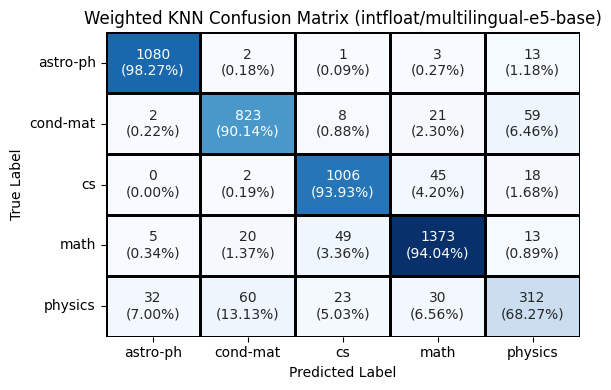

In [ ]:
import os
os.makedirs("pdf/Figures", exist_ok=True)
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "Weighted KNN Confusion Matrix (intfloat/multilingual-e5-base)", save_path="pdf/Figures/embeddings_confusion_matrix_e5_original.pdf")

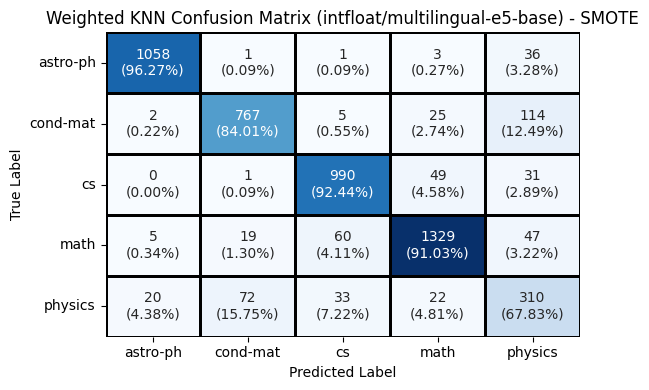

In [ ]:
import os
os.makedirs("pdf/Figures", exist_ok=True)
plot_confusion_matrix(y_test, knn_embeddings_labels_smote, sorted_labels, "Weighted KNN Confusion Matrix (intfloat/multilingual-e5-base) - SMOTE", save_path="pdf/Figures/embeddings_confusion_matrix_e5_smote.pdf")

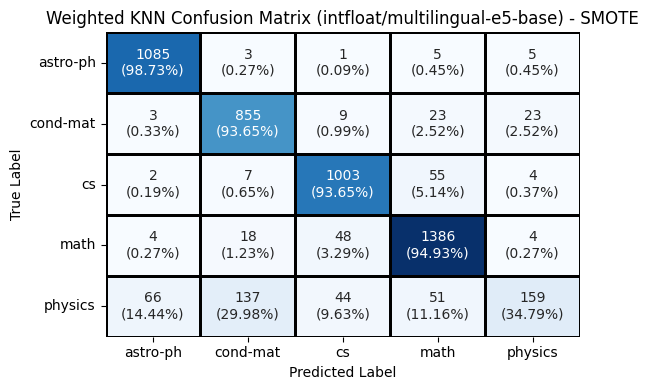

In [ ]:
import os
os.makedirs("pdf/Figures", exist_ok=True)
plot_confusion_matrix(y_test, knn_embeddings_labels_ros, sorted_labels, "Weighted KNN Confusion Matrix (intfloat/multilingual-e5-base) - SMOTE", save_path="pdf/Figures/embeddings_confusion_matrix_e5_ros.pdf")

## EMBEDDING MODEL: allenai-specter

### 4. Mã hóa văn bản (Sentence Embeddings)




In [ ]:
# Embedding Model: allenai-specter
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = 'allenai-specter',
        normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def transform(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> List[List[float]]:
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))

#### Orginal Dataset

In [ ]:
embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of X_train_embeddings: (20000, 768)
Shape of X_test_embeddings: (5000, 768)



#### Upsampling Dataset (SMOTE)

In [ ]:
# === SMOTE ===
print("Before SMOTE:", Counter(y_train))
# smote = SMOTE(random_state=42, k_neighbors=3)
smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_train_embeddings, y_train)
print("After SMOTE:", Counter(y_smote))
print(f"Shape after SMOTE: {X_smote.shape}\n")

Before SMOTE: Counter({3: 5842, 0: 4396, 2: 4285, 1: 3652, 4: 1825})
After SMOTE: Counter({3: 5842, 4: 5842, 0: 4396, 2: 4285, 1: 3652})
Shape after SMOTE: (24017, 768)



#### Upsampling Dataset (Random Oversampling)

In [ ]:
# === Random Oversampling ===
print("Before Random Oversampling:", Counter(y_train))
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_embeddings, y_train)
print("After Random Oversampling:", Counter(y_ros))
print(f"Shape after Random Oversampling: {X_ros.shape}\n")

Before Random Oversampling: Counter({3: 5842, 0: 4396, 2: 4285, 1: 3652, 4: 1825})
After Random Oversampling: Counter({3: 5842, 1: 5842, 2: 5842, 4: 5842, 0: 5842})
Shape after Random Oversampling: (29210, 768)



### 5. Huấn luyện và đánh giá mô hình phân loại





In [ ]:
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_emsemble_model(ensemble_model, X_train_embeddings, y_train, X_test_embeddings, y_test)
print("Accuracies for ensemble model (original dataset):")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for ensemble model (original dataset):
Embeddings: 0.9240


In [ ]:
knn_embeddings_labels_smote, knn_embeddings_accuracy_smote, knn_embeddings_report_smote = train_and_test_emsemble_model(ensemble_model, X_smote, y_smote, X_test_embeddings, y_test)
print("Accuracies for ensemble model (SMOTE):")
print(f"Embeddings: {knn_embeddings_accuracy_smote:.4f}")

Accuracies for ensemble model (SMOTE):
Embeddings: 0.9222


In [ ]:
knn_embeddings_labels_ros, knn_embeddings_accuracy_ros, knn_embeddings_report_ros = train_and_test_emsemble_model(ensemble_model, X_ros, y_ros, X_test_embeddings, y_test)
print("Accuracies for ensemble model (Random oversampling):")
print(f"Embeddings: {knn_embeddings_accuracy_ros:.4f}")

Accuracies for ensemble model (Random oversampling):
Embeddings: 0.9086


In [ ]:
import pandas as pd

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(knn_embeddings_report).transpose()

# Display the DataFrame
display(report_df)

,precision,recall,f1-score,support
astro-ph,0.966786,0.979982,0.973339,1099.000
cond-mat,0.909188,0.932092,0.920498,913.000
cs,0.917897,0.929038,0.923434,1071.000
math,0.943759,0.942466,0.943112,1460.000
physics,0.786765,0.702407,0.742197,457.000
accuracy,0.924000,0.924000,0.924000,0.924
macro avg,0.904879,0.897197,0.900516,5000.000
weighted avg,0.922619,0.924000,0.923048,5000.000


In [ ]:
import pandas as pd

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(knn_embeddings_report_smote).transpose()

# Display the DataFrame
display(report_df)

,precision,recall,f1-score,support
astro-ph,0.967684,0.980892,0.974243,1099.0000
cond-mat,0.891121,0.923330,0.906939,913.0000
cs,0.924908,0.943044,0.933888,1071.0000
math,0.941821,0.942466,0.942143,1460.0000
physics,0.785530,0.665208,0.720379,457.0000
accuracy,0.922200,0.922200,0.922200,0.9222
macro avg,0.902213,0.890988,0.895519,5000.0000
weighted avg,0.920340,0.922200,0.920733,5000.0000


In [ ]:
import pandas as pd

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(knn_embeddings_report_ros).transpose()

# Display the DataFrame
display(report_df)

,precision,recall,f1-score,support
astro-ph,0.940818,0.983621,0.961744,1099.0000
cond-mat,0.874490,0.938664,0.905441,913.0000
cs,0.905109,0.926237,0.915551,1071.0000
math,0.913816,0.951370,0.932215,1460.0000
physics,0.878431,0.490153,0.629213,457.0000
accuracy,0.908600,0.908600,0.908600,0.9086
macro avg,0.902533,0.858009,0.868833,5000.0000
weighted avg,0.907471,0.908600,0.902553,5000.0000


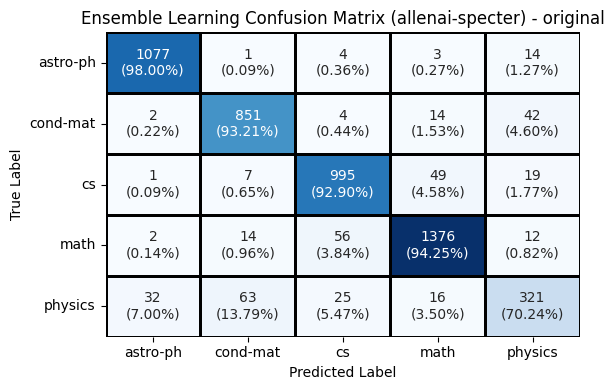

In [ ]:
import os
os.makedirs("pdf/Figures", exist_ok=True)
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "Ensemble Learning Confusion Matrix (allenai-specter) - original", save_path="pdf/Figures/embeddings_confusion_matrix_as_original.pdf")

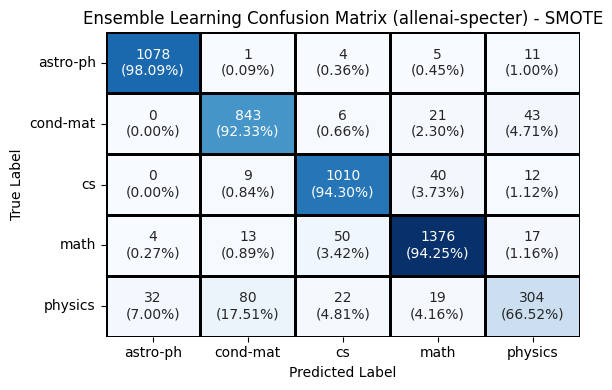

In [ ]:
import os
os.makedirs("pdf/Figures", exist_ok=True)
plot_confusion_matrix(y_test, knn_embeddings_labels_smote, sorted_labels, "Ensemble Learning Confusion Matrix (allenai-specter) - SMOTE", save_path="pdf/Figures/embeddings_confusion_matrix_as_smote.pdf")

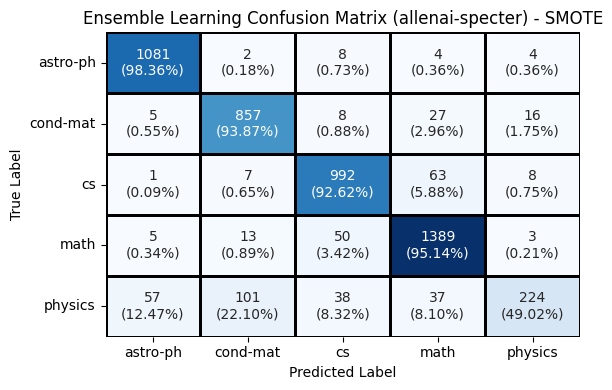

In [ ]:
import os
os.makedirs("pdf/Figures", exist_ok=True)
plot_confusion_matrix(y_test, knn_embeddings_labels_ros, sorted_labels, "Ensemble Learning Confusion Matrix (allenai-specter) - SMOTE", save_path="pdf/Figures/embeddings_confusion_matrix_as_ros.pdf")